In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D, concatenate
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
#ds_name = "synthetic_holograms_v02_ft_ac_d_amplitude_float32.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_d_real_imag_float32.nc"
ds_name = "synthetic_holograms_v02_ft_ac_dzxy_amplitude_real_imag_float32_histogram.nc"
#ds_name = "synthethic_holograms_v0_ft_ac_d_amplitude_float32_histogram.nc"  # single particle histograms
#ds_name = "synthethic_holograms_v0_ft_ac_dzxy_amplitude_real_imag_float32_histogram.nc"  # single particle

num_epochs = 30

ds = xr.open_dataset(ds_path+ds_name)  # file with mean (DC) value removed

In [3]:
# flatten the histogram to a single axis with the hologram number remaining as the first axis
particle_labels = ds['particle_histogram'].stack(histogram_line=ds['particle_histogram'].dims[1:]).values

all_labels = pd.DataFrame(particle_labels, index=ds['hologram_number'])

# Fourier Transform the histograms
#particle_labels_ft0 = np.fft.fft(particle_labels,axis=0)[:,:particle_labels.shape[1]//2]
#particle_labels_ft = np.concatenate((np.real(particle_labels_ft0),np.imag(particle_labels_ft0)),axis=1)
#print(particle_labels_ft.shape)
#all_labels = pd.DataFrame(particle_labels_ft, index=ds['hologram_number'])

In [4]:
ds['particle_histogram'].dims[1:]

('d_bin_centers', 'z_bin_centers', 'x_bin_centers', 'y_bin_centers')

In [5]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
train_labels = all_labels.iloc[valid_index:split_index]
test_labels = all_labels.iloc[split_index:]
val_labels = all_labels.iloc[:valid_index]

#scaler = MinMaxScaler()
#scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
#scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)
#scaled_val_labels = pd.DataFrame(scaler.transform(val_labels), index=val_labels.index, columns=val_labels.columns)

#scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(train_labels, index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(test_labels, index=test_labels.index, columns=test_labels.columns)
scaled_val_labels = pd.DataFrame(val_labels, index=val_labels.index, columns=val_labels.columns)

In [6]:
if not "channel" in ds["image_ft"].dims:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize',"channel")

In [7]:
in_data.dims

('hologram_number', 'xsize', 'ysize', 'channel')

In [8]:
ds["image_ft"].max()

<xarray.DataArray 'image_ft' ()>
array(2.313813)

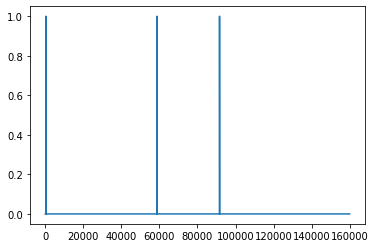

In [9]:
plt.figure(); plt.plot(scaled_train_labels.values[10,:])

In [10]:
scaled_in_data = in_data / 2

In [11]:
nn_descript = 'CNN_binary_crossentropy'

conv_input = Input(shape=in_data.shape[1:])  
conv_1 = SeparableConv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)

conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(all_labels.shape[1],activation='sigmoid')(dense_2)  # number of outputs determined by the parameters we are training to
mod = Model(conv_input, out)
mod.compile(optimizer="rmsprop", loss="binary_crossentropy",metrics=['acc'])
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 400, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 600, 400, 8)       107       
_________________________________________________________________
activation (Activation)      (None, 600, 400, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 100, 8)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 100, 16)      3216      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 100, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 25, 16)        0     

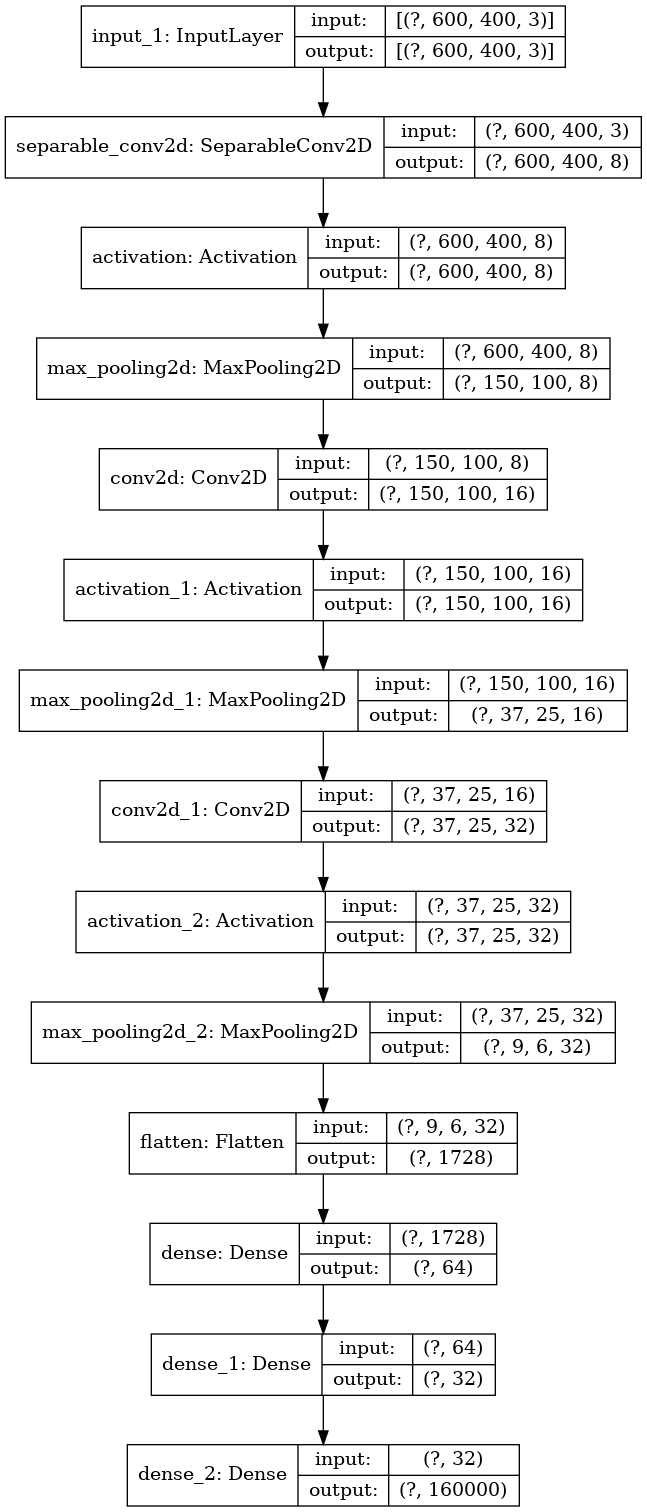

In [12]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+nn_descript+'_'+ds_name.replace(".nc","")+".png")

In [13]:
history = mod.fit(scaled_in_data[valid_index:split_index].values, scaled_train_labels.values, 
                  batch_size=16, epochs=num_epochs, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))

Train on 5000 samples, validate on 2000 samples
Epoch 1/30
5000/5000 [==============================] - 210s 42ms/sample - loss: 0.0130 - acc: 0.9984 - val_loss: 2.3908e-04 - val_acc: 1.0000
Epoch 2/30
5000/5000 [==============================] - 214s 43ms/sample - loss: 2.3018e-04 - acc: 1.0000 - val_loss: 2.2971e-04 - val_acc: 1.0000
Epoch 3/30
5000/5000 [==============================] - 206s 41ms/sample - loss: 2.2691e-04 - acc: 1.0000 - val_loss: 2.3528e-04 - val_acc: 1.0000
Epoch 4/30
5000/5000 [==============================] - 207s 41ms/sample - loss: 2.2405e-04 - acc: 1.0000 - val_loss: 2.2654e-04 - val_acc: 1.0000
Epoch 5/30
5000/5000 [==============================] - 215s 43ms/sample - loss: 2.2192e-04 - acc: 1.0000 - val_loss: 2.2851e-04 - val_acc: 1.0000
Epoch 6/30
5000/5000 [==============================] - 216s 43ms/sample - loss: 2.1972e-04 - acc: 1.0000 - val_loss: 2.2507e-04 - val_acc: 1.0000
Epoch 7/30
5000/5000 [==============================] - 210s 42ms/sample -

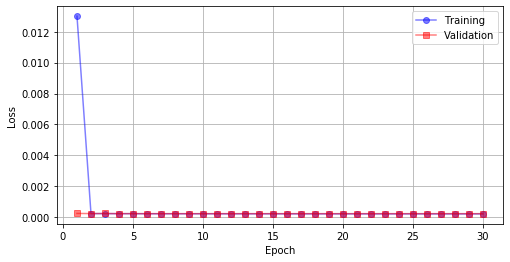

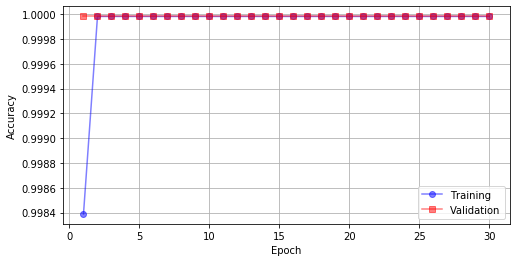

In [14]:
epochs = np.arange(len(history.history['acc']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


In [15]:
# can skip the training process and just load the CNN model
#mod = load_model("holodec_ft_cnn.h5")

In [16]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 69.089605 seconds
for 0.0069089605 seconds per hologram


In [17]:
save_model(mod, ds_path+"/models/holodec_histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"{num_epochs}epochs"+".h5", save_format="h5")

In [18]:
preds_out.shape

(10000, 160000)

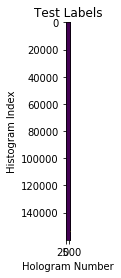

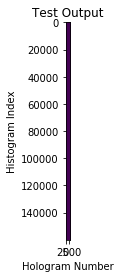

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.imshow(scaled_test_labels.values.T)
axes.set_xlabel('Hologram Number')
axes.set_ylabel('Histogram Index')
axes.set_title('Test Labels')
plt.savefig("results/Label_Histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.imshow(preds_out[split_index:,:].T,vmin=0,vmax=0.3)
axes.set_xlabel('Hologram Number')
axes.set_ylabel('Histogram Index')
axes.set_title('Test Output')
plt.savefig("results/Output_Histogram_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


ValueError: x and y must have same first dimension, but have shapes (20,) and (160000,)

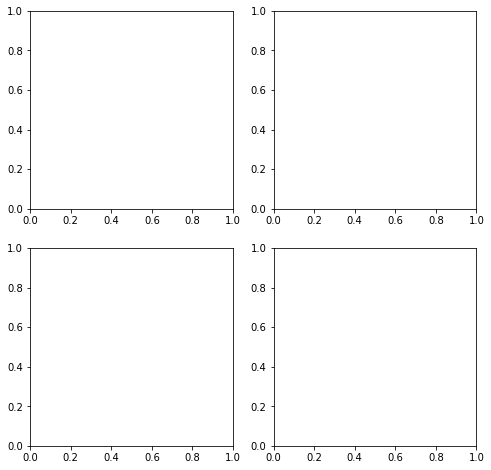

In [20]:
hindices = [10,234,500,1293]
fig,axes = plt.subplots(2,2,figsize=(8,8))
axes=axes.ravel()
for hi,holo_index in enumerate(hindices):
    axes[hi].plot(ds['particle_histogram'].d_bin_centers.values,test_labels.iloc[holo_index,:],label=f'Test Label {holo_index}')
    axes[hi].plot(ds['particle_histogram'].d_bin_centers.values,preds_out[split_index+holo_index,0:],label=f'Test Output {holo_index}')
    axes[hi].set_ylabel('Probability')
    axes[hi].set_xlabel('Particle Diameter [$\mu m$]')
    #axes[hi].set_title(f'Hologram {holo_index}')
    axes[hi].grid(b=True)
    axes[hi].legend()

plt.savefig("results/Example_Hists_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")

In [ ]:
part_indices = np.nonzero(scaled_test_labels.values)
pred_values = (preds_out[split_index:,:])[part_indices]
label_moments = []
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:],axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**2,axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**3,axis=1)/np.sum(scaled_test_labels.values,axis=1))
label_moments.append(np.sum(scaled_test_labels.values*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**4,axis=1)/np.sum(scaled_test_labels.values,axis=1))

pred_moments = []
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:],axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**2,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**3,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
pred_moments.append(np.sum(preds_out[split_index:,:]*ds['particle_histogram'].d_bin_centers.values[np.newaxis,:]**4,axis=1)/np.sum(preds_out[split_index:,:],axis=1))
std_pred = np.sqrt(pred_moments[1]-pred_moments[0]**2)

mean_error = []
std_error = []
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ai,ax in enumerate(axes.ravel()):
    if ai == 0:
        mean_error.append(np.mean(pred_moments[ai]-label_moments[ai]))
    else:
        mean_error.append(np.abs(np.mean(pred_moments[ai]-label_moments[ai]))**(1/(1.0+ai)))
    std_error.append(np.std(pred_moments[ai]-label_moments[ai])**(1/(1.0+ai)))
    ax.scatter(label_moments[ai]**(1/(1.0+ai)),pred_moments[ai]**(1/(1.0+ai)), 1, 'k')
    diag = np.linspace(label_moments[ai].min()**(1/(1.0+ai)), label_moments[ai].max()**(1/(1.0+ai)), 10)
    ax.plot(diag, diag, 'b--' )
    plt.text(0.1,0.9,f"${mean_error[ai]:.1f} \pm {std_error[ai]:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
    ax.grid(b=True)
    ax.set_title('moment %d'%(ai+1))
plt.savefig("results/Moment_Scatter_"+nn_descript+'_'+ds_name.replace(".nc","")+f"_{num_epochs}epochs"+".png", dpi=200, bbox_inches="tight")


In [ ]:
np.mean(pred_moments[0]-label_moments[0])

In [ ]:
np.mean((pred_moments[0]-label_moments[0])**2)

In [ ]:
np.mean(pred_moments[1]-pred_moments[0]**2)